In [1]:
%load_ext autoreload 
%autoreload 2

import yaml
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path, PurePath
import torch
from torch.utils.data import DataLoader, ConcatDataset
import torchaudio
from IPython.display import Audio

from fusanet_utils.datasets.external import get_label_transforms, SINGAPURA
from fusanet_utils.datasets.aumilab import AUMILAB

from fusanet_utils.datasets.fusa import FUSA_dataset
from fusanet_utils.transforms import Collate_and_transform
    
models_metadata = {0: {'name': 'no-pretrained-valid-loss', 
                       'path': Path('../../experiments/Poliphonic-PANN-sed-no-pretrained-valid-loss/')},
                   1: {'name': 'pink-noise', 
                       'path': Path('../../experiments/Poliphonic-PANN-sed-pink-noise/')},
                   2: {'name': 'pink-noise-2', 
                       'path': Path('../../experiments/Poliphonic-PANN-sed-pink-noise-2/')},
                   3: {'name': 'pink-noise-clipping', 
                       'path': Path('../../experiments/Poliphonic-PANN-sed-pink-noise-clipping/')},
                  }

In [3]:
dataset = SINGAPURA('../..')

In [ ]:
preds_soft, labels, distances, file_names = {}, {}, {}, {}
for model_idx in [0, 1, 2, 3]:
    experiment_path = models_metadata[model_idx]['path']
    print(experiment_path)
    model = torch.load(str(experiment_path / 'model.pt'))
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters number: {pytorch_total_params}')
    print(f'Trainable parameters number: {pytorch_trainable_params}')
    model.eval()
    params = yaml.safe_load(open(str(experiment_path / 'params.yaml')))
    fusa_dataset = FUSA_dataset(ConcatDataset([dataset]), params=params)
    fusa_loader = DataLoader(fusa_dataset, batch_size=10, shuffle=False, pin_memory=True, num_workers=2,
                             collate_fn=Collate_and_transform(params["features"]))
    preds_model, labels_model, distances_model, filenames_model = [], [], [], []
    with torch.no_grad():
        for sample in tqdm(fusa_loader):
            preds_model.append(model(sample).numpy())
            labels_model.append(sample['label'].numpy())
            distances_model.append(sample['distance'].numpy())
            filenames_model.append(sample['filename'])
    preds_soft[model_idx] = np.concatenate(preds_model)
    labels[model_idx] = np.concatenate(labels_model)
    distances[model_idx] = np.concatenate(distances_model)
    file_names[model_idx] = np.concatenate(filenames_model)

In [ ]:
np.save('SINGAPURA/preds_soft.npy', preds_soft)
np.save('SINGAPURA/labels.npy', labels)
np.save('SINGAPURA/distances.npy', distances)
np.save('SINGAPURA/filenames.npy', file_names)

In [340]:
preds_soft = np.load('SINGAPURA/preds_soft.npy', allow_pickle=True).item()
labels = np.load('SINGAPURA/labels.npy', allow_pickle=True).item()
distances = np.load('SINGAPURA/distances.npy', allow_pickle=True).item()
file_names = np.load('SINGAPURA/filenames.npy', allow_pickle=True).item()

In [341]:
preds_soft[0].shape, labels[0].shape, file_names[0].shape

((4727, 1001, 33), (4727, 1001, 24), (4727,))

In [342]:
dataset.categories, len(dataset.categories)

(['alerts/alarms',
  'alerts/braking and skidding',
  'alerts/horns',
  'alerts/others',
  'alerts/siren',
  'animal/bird',
  'animal/dog',
  'animal/others',
  'environmental/others',
  'environmental/rain',
  'environmental/wind',
  'humans/crowd',
  'humans/others',
  'humans/shouting',
  'humans/talk',
  'mechanical/cutting',
  'mechanical/explosives',
  'mechanical/impact',
  'mechanical/others',
  'music/music',
  'vehicles/bus',
  'vehicles/cars',
  'vehicles/motorcycles',
  'vehicles/others'],
 24)

In [343]:
th = 0.45
models = ['no-pretrained-valid-loss', 'pink-noise', 'pink-noise-2', 'pink-noise-clipping']
preds = [preds_soft[model] > th for model in range(len(models))]
idx_others = [3, 7, 8, 18, 23] #indices de clases FUSA donde SPASS no contiene clase (others)
for model in [0,1,2,3]:
    labels[model] = np.delete(labels[model], idx_others, 2)
preds[0].shape, labels[0].shape

((4727, 1001, 33), (4727, 1001, 19))

In [305]:
#clases FUSA donde si hay clases SPASS
fusa_classes = [  'alerts/alarms',
                  'alerts/braking and skidding',
                  'alerts/horns',
                  'alerts/siren',
                  'animal/bird',
                  'animal/dog',
                  'environmental/rain',
                  'environmental/wind',
                  'humans/crowd',
                  'humans/others',
                  'humans/shouting',
                  'humans/talk',
                  'mechanical/cutting',
                  'mechanical/explosives',
                  'mechanical/impact',
                  'music/music',
                  'vehicles/bus',
                  'vehicles/cars',
                  'vehicles/motorcycles']
len(fusa_classes)

19

In [378]:
#Diccionario con clases FUSA y SPASS (33 clases)
fusa_taxonomy_int = {
    0: [3],
    1: [6],
    2: [17],
    3: [25],
    4: [5],
    5: [13],
    6: [22],
    7: [32],
    8: [11],
    9: [26],
    10: [24],
    11: [27],
    12: [12],
    13: [15, 16],
    14: [18],
    15: [21],
    16: [7, 8, 28, 29],
    17: [9, 10],
    18: [19, 20],
}

[b827ebb954cd][2020-08-22T09-39-04Z][manual][---][de313d12d7f31937615be80cc47a1ad9][]-110.flac


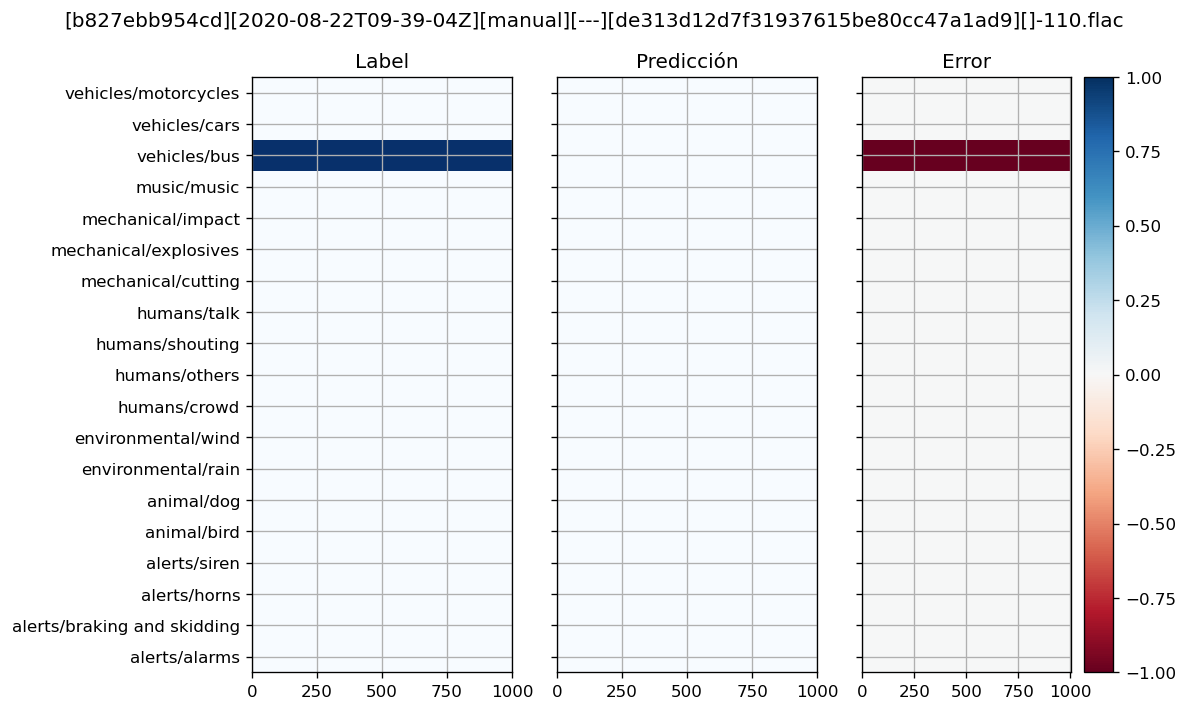

In [344]:
def plot_file_prediction(model: int, idx: int):
    print(file_names[model][idx])
    pred = np.stack([np.amax(preds[model][idx][:, fusa_taxonomy_int[macro]], axis=1) for macro in range(len(fusa_classes))])
    label = labels[model][idx].T
    fig, ax = plt.subplots(1, 3, figsize=(10, 6), facecolor='w', dpi=120,
                           tight_layout=True, sharex=True, sharey=True)
    ax[0].pcolormesh(label, cmap=plt.cm.Blues, vmin=0, vmax=1)
    ax[1].pcolormesh(pred, cmap=plt.cm.Blues, vmin=0, vmax=1)
    fig.suptitle(file_names[model][idx])
    ax[0].set_title('Label')
    ax[1].set_title('Predicción')
    cmap = ax[2].pcolormesh((pred - label), cmap=plt.cm.RdBu, vmin=-1, vmax=1)
    fig.colorbar(cmap)
    ax[2].set_title('Error')
    ax[0].set_yticks(np.arange(0, len(fusa_classes), step=1) + 0.5)
    ax[0].set_yticklabels((fusa_classes));
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    
plot_file_prediction(2, 0)

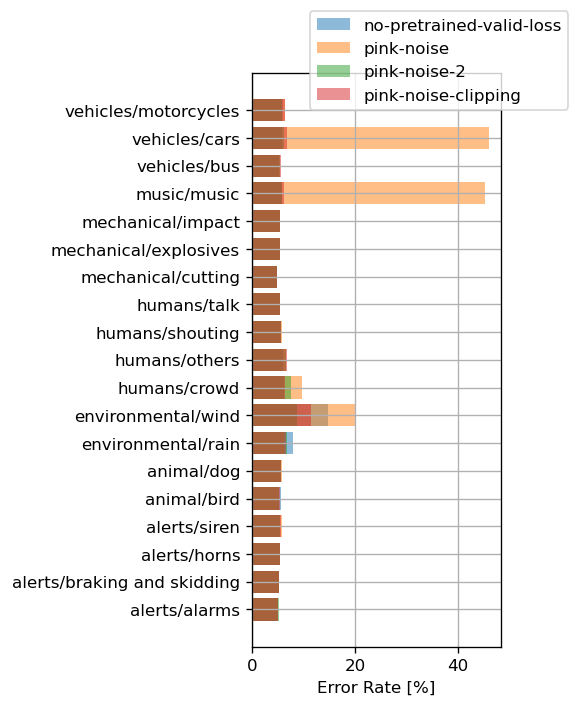

In [345]:
fig, ax = plt.subplots(figsize=(5, 6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)

for k, model_name in enumerate(models):
    pred_macro = np.stack([np.amax(preds[k][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(fusa_classes))])
    label_macro = labels[k].reshape(pred_macro.shape)

    insertions = np.mean((pred_macro == 1) & (label_macro==0), axis=(1, 2))
    deletions = np.mean((pred_macro == 0) & (label_macro==1), axis=(1, 2))

    error_rate = 100*(insertions + deletions)
    ax.barh(y=fusa_classes, width=error_rate, label=model_name, alpha=0.5)
ax.legend(bbox_to_anchor=(0.2, 1.02, 1., .102))
ax.grid()
ax.set_xlabel('Error Rate [%]')

In [376]:
len(fusa_classes)

19

In [383]:
import pandas as pd

df = []
for idx, model_name in enumerate(models):
    pred_macro = np.stack([np.amax(preds[k][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(fusa_classes))])
    label_macro = labels[k].reshape(pred_macro.shape)

    insertions = np.mean((pred_macro == 1) & (label_macro==0), axis=(1, 2))
    deletions = np.mean((pred_macro == 0) & (label_macro==1), axis=(1, 2))

    error_rate = 100*(insertions + deletions)
    
    df.append(pd.Series(error_rate, index=fusa_classes, name=models_metadata[idx]['name']))
    
print(pd.concat(df, axis=1).to_latex(float_format="%.2f"))

\begin{tabular}{lrrrr}
\toprule
{} &  no-pretrained-valid-loss &  pink-noise &  pink-noise-2 &  pink-noise-clipping \\
\midrule
alerts/alarms               &                      5.16 &        5.16 &          5.16 &                 5.16 \\
alerts/braking and skidding &                      5.35 &        5.35 &          5.35 &                 5.35 \\
alerts/horns                &                      5.53 &        5.53 &          5.53 &                 5.53 \\
alerts/siren                &                      5.55 &        5.55 &          5.55 &                 5.55 \\
animal/bird                 &                      5.72 &        5.72 &          5.72 &                 5.72 \\
animal/dog                  &                      5.69 &        5.69 &          5.69 &                 5.69 \\
environmental/rain          &                      8.00 &        8.00 &          8.00 &                 8.00 \\
environmental/wind          &                     14.70 &       14.70 &         14.70 & 

/tmp/ipykernel_3551331/2806278866.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(df, axis=1).to_latex(float_format="%.2f"))


In [356]:
eps = torch.finfo(torch.float).eps

0 0
0 64
29 611
383 6606


Text(0.5, 0, 'F1-Score [%]')

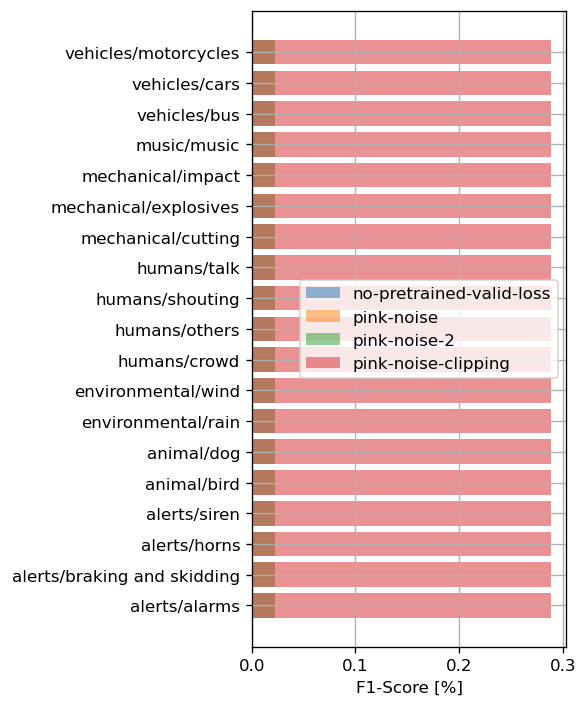

In [361]:
fig, ax = plt.subplots(figsize=(5, 6), facecolor='w', dpi=120,
                       tight_layout=True, sharey=True, sharex=True)
for k, model_name in enumerate(models):
    pred_macro = np.stack([np.amax(preds[k][:, :, fusa_taxonomy_int[macro]], axis=-1) for macro in range(len(fusa_classes))])
    label_macro = labels[k].reshape(pred_macro.shape)
    
    TP = np.sum((pred_macro[k]==1) & (label_macro[k]==1), axis=(0, 1))
    FP = np.sum((pred_macro[k]==1) & (label_macro[k]==0), axis=(0, 1)) #insertions
    FN = np.sum((pred_macro[k]==0) & (label_macro[k]==1), axis=(0, 1)) #deletions
    prec = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)
    f1_score = 2 * prec * recall / (prec + recall + eps)
    ax.barh(y=fusa_classes, width=100*f1_score, alpha=0.5, label=model_name)

ax.legend(loc='center right')
ax.grid()
ax.set_xlabel('F1-Score [%]')

In [362]:
fusa_classes

['alerts/alarms',
 'alerts/braking and skidding',
 'alerts/horns',
 'alerts/siren',
 'animal/bird',
 'animal/dog',
 'environmental/rain',
 'environmental/wind',
 'humans/crowd',
 'humans/others',
 'humans/shouting',
 'humans/talk',
 'mechanical/cutting',
 'mechanical/explosives',
 'mechanical/impact',
 'music/music',
 'vehicles/bus',
 'vehicles/cars',
 'vehicles/motorcycles']

In [363]:
categories = {}
for k, category in enumerate(dataset.categories):
    categories[k] = category
inv_categories = {}
for key, values in categories.items():
    inv_categories[values] = int(key)
    
macro_classes = ['human', 'animal', 'alerts', 'music', 'environmental', 'mechanical', 'vehicle']
fusa_taxonomy = {0: ['humans/crowd', 'humans/shouting', 'humans/talk', 'humans/others'],
                 1: ['animal/bird', 'animal/dog'], 
                 2: ['alerts/siren', 'alerts/alarms', 'alerts/horns', 'alerts/braking and skidding'],
                 3: ['music/music'],
                 4: ['environmental/rain', 'environmental/wind'],
                 5: ['mechanical/cutting', 'mechanical/impact', 'mechanical/explosives'],
                 6: ['vehicles/cars', 'vehicles/bus', 'vehicles/motorcycles']
                }
fusa_taxonomy_int = {}
for key, values in fusa_taxonomy.items():
    transformed_values = []
    for value in values:
        transformed_values.append(inv_categories[value])
    fusa_taxonomy_int[key] = transformed_values
        
inv_taxonomy = {}
for key, values in fusa_taxonomy_int.items():
    for value in values:
        inv_taxonomy[value] = key